## **TORCH.AUTOGRAD를 사용한 자동 미분**


---


신경망 학습시 가장 자주 사용되는 알고리즘 중 하나가 바로 **역전파**다. 역전파를 통해 주어진 매개변수(W, b)에 대한 **손실함수의 기울기(gradient)**에 따라 해당 매개변수를 조정한다.  

PyTorch에서는 ***torch.autograd***라는 **자동 미분 엔진**이 내장되어 있어, 모든 계산 그래프에 대한 변화도(기울기)의 자동 계산을 지원한다.   

아래의 예제는 입력 x, 매개변수 w,b와 일부 손실함수(*binary_cross_entropy*)가 있는 가장 간단한 단일 계층 신경망을 가정해 정의한 것이다.

In [ ]:
import torch

x=torch.ones(5) #1로 채워진 1*5 행렬
y=torch.zeros(3) #0으로 채워진 1*3 행렬
w=torch.randn(5,3, requires_grad=True) #torch.randn(): 평균이 0이고 표준편차가 1인 정규분포에서
                                       #무작위로 추출한 난수를 생성해 집어넣은 Tensor를 반환
                                       #Size는 3*5
b=torch.randn(3, requires_grad=True)
z=torch.matmul(x, w)+b
loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)

### **+) 잠깐! Cross Entropy(교차 엔트로피)란?**

머신러닝에서는 분류 모델이 얼마나 잘 수행되는지 측정하기 위해 Loss(Error)값을 지표로 사용한다. 0과 1 사이의 숫자로 표현되며, Loss가 0에 가까울수
좋은 모델이다.

***Cross Entropy Loss***는 머신러닝에서 신경망을 훈련하는 데 사용되는 가장 일반적인 손실 함수 중 하나다. **머신러닝 분류 모델에서 발견된 확률 분포와 예측 분포의 차이**를 측정한다. 예로, 동전 던지기에서 특정 값(odd)를 찾는 경우 해당 정보가 0.5, 0.5(앞면과 뒷면)로 저장된다.

***Binary Cross Entropy Loss***도 마찬가지로 학습을 통해 얻은 확률 분포와 예측 분포간의 차를 측정하는데, Cross Entropy와 달리 **하나의 확률만 저장**한다. 동전던지기에서 만약 앞면이 나올 확률이 0.7로 측정되었다면, 이를 저장하고 뒷면이 나올 확률을 0.3으로 가정한다.

이러한 특징 때문에 ***Binary Cross Entropy Loss***(Log loss)는 **결과값이 두개**인 시나리오에서 사용되며, **3개 이상의 분류 문제에서는 Cross Entropy Loss**가 자주 사용된다.

## Tensor, Function과 연산그래프(Computational graph)

위 예제 코드를 연산 그래프로 정의하면 아래와 같다.

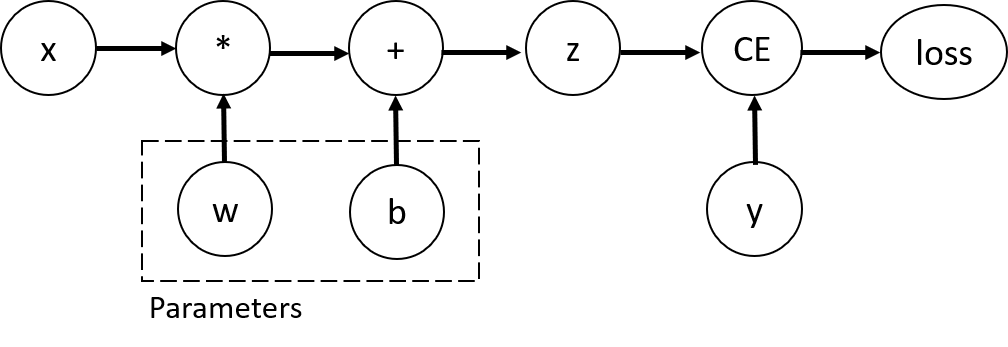

해당 신경망에서, **w,b는 최적화 해야하는 매개변수**이고, 이 매개변수들에 대한 손실 함수의 기울기를 계산할 수 있어야 한다. *torch.autograd*의 ***requires_grad*** 속성을 설정하면 해당 tensor의 가중치를 학습시킬 수 있다.

연산을 위해 텐서에 적용되는 함수들은 *torch.autograd.Function* 클래스의 객체다. 이 객체는 순전파 방향의 함수 계산 방법, 역전파 방향의 도함수(derivative)계산 방법을 알고 있으며, 해당 함수에 대한 정보는 텐서의 ***grad_fn*** 속성에 저장된다.

In [ ]:
print(f"Gradient fuction for z = {z.grad_fn}")#requires_grad=True
                                              #tensor 생성시 requires_grad 값을 줘도 되고,
                                              #나중에 x.requires_grad_(True) 메서드를 사용해 설정해도 된다.
print(f"Gradient fuction for loss = {loss.grad_fn}") #requires_grad=True
                                                     #tensor에 적용된 함수의 정보를 출력할 수 있

Gradient fuction for z = <AddBackward0 object at 0x7f588717db70>
Gradient fuction for loss = <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f594c30ab30>


## **변화도(Gradient) 계산하기**

신경망에서 매개변수의 가중치를 최적화하려면, **매개변수에 대한 손실함수의 도함수(derivative)를 계산**해야 한다. (∂loss/∂𝑤, ∂loss/∂𝐛)

*.backward*를 통해 계산된 gradient의 실제값은 *.grad*에 들어가고, backward가 수행 될 때 마다 *.grad*에 **gradient값이 accumulate 된다**.

아래에서는 도함수 계산을 위해, *loss.backward*를 호출한 다음 *w.grad*와 *b.grad*에서 값을 가져왔다.

In [ ]:
loss.backward()
print(w.grad)
print(b.grad)

tensor([[0.2743, 0.2516, 0.3184],
        [0.2743, 0.2516, 0.3184],
        [0.2743, 0.2516, 0.3184],
        [0.2743, 0.2516, 0.3184],
        [0.2743, 0.2516, 0.3184]])
tensor([0.2743, 0.2516, 0.3184])


## 변화도 추적 멈추기!
만약, 모델 학습 후 입력 데이터를 단순히 적용하기만 하는 경우와 같이 순전파 연산만 필요한 경우에는, **requires_grad가 필요하지 않을 수도 있다**.    
이럴 경우, with를 써서 연산 코드를 ***torch.no_grad()***블록으로 묶으면 기울기 구하는 것을 특정 블럭에 잠시 적용하지 않을 수 있다.

In [ ]:
import torch
x = torch.ones(5)  # input tensor
y = torch.zeros(3)  # expected output
w = torch.randn(5, 3, requires_grad=True)
b = torch.randn(3, requires_grad=True)
z = torch.matmul(x, w)+b
loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)

In [ ]:
z = torch.matmul(x, w)+b
print(z.requires_grad) #repuires_grad = True

with torch.no_grad():
    z = torch.matmul(x, w)+b
print(z.requires_grad) #requires_grad = False

True
False


다른 방법으로, ***tensor.detach()*** 메소드를 사용해 gradient 계산을 멈출 수 있다.

In [ ]:
z = torch.matmul(x, w)+b
z_det = z.detach()

print(z_det.requires_grad)

False


### **Gradient 계산을 멈추는 이유가 무엇인가요?**
- 신경망의 일부 매개변수를 **고정된 매개변수(frozen parameter)**로 표시한다.
- 변화도를 추적하지 않는 텐서의 연산이 더 효울적이다. => 순전파 단계만 수행할 때가 **연산 속도가 더 빠르다**.

## **연산 그래프에 대한 추가 정보**

개념적으로, autograd는 데이터(tensor)의 실행된 모든 연산들(및 연산 결과가 새로운 텐서인 경우도 포함하여)의 기록을 함수 객체로 구성된 방향성 **비순환 그래프(DAG; Directed Acyclic Graph)에 저장**한다.
<br><br>

### **+)DAG?**   
비순환 그래프에 대해 알아보기 전에 먼저 순환 그래프 부터 알아보자면,




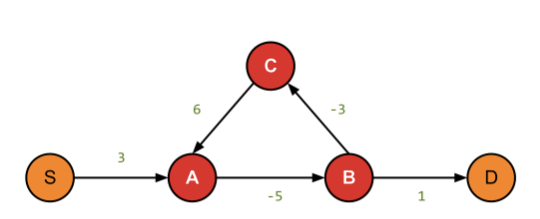

위 그래프와 같이, 순환이 계속해서 발생할 수 있는 형태의 그래프를 **순환그래프(Negative Graph)**라고 한다. 해당 그래프에서 최단경로를 알아내는 알고리즘은 Dijkstra와 Bellman-Ford 등이 있다.
<br><br>
**비순환 그래프**는 위와 달리 순환되는 구간이 없는 그래프를 말한다. 즉, **순환 사이클이 없고, 비가역적 일방향성을 가진다.**

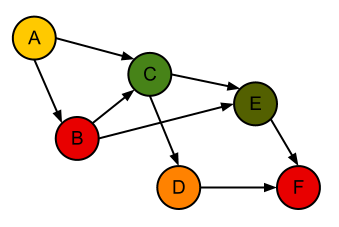

### **DAG알고리즘:**

일방향적이 아닌 다방향성의 비순환적 그래프를 활용하며, 비순환 구조가 무작위를 생성된다.

다시 돌아와서, 이런 DAG에 잎(leave)에는 입력 텐서가 들어가고, 뿌리(root)에는 결과 텐서가 저장된다. 이 그래프를 뿌리에서부터 잎까지 추적하면 **연쇄 법칙(chain rule)**에 따라 **변화도를 자동으로 계산**할 수 있다.

### **각 단계별 작업**

**[순전파 단계]**
- 요청된 연산을 수행해 결과 텐서를 계산
- DAG에 Gradient function을 유지(maintain)함. (이따가 사용할 거거등요)

**[역전파 단계]**
- 각 *.grad_fn*으로부터 기울기를 계산
- 각 텐서의 *.grad* 속성에 계산 결과 쌓기(accumulate)
- 연쇄 법칙으로 모든 잎 텐서들에 전파(propagate)

<br>

**+) 참고**

PyTorch의 DAG는 **동적(Dynamic)임**. 일단 *.backward()*가 호출되고 나면, **autograd는 아예 새로 생성된 그래프를 채움.** 이런 특징 때문에, 모델에서 흐름제어(control flow)구문 사용이 가능함.   
&nbsp; ➡ 반복할 때 마다 필요시 모양이나 크기, 연산을 바꿀 수 있음.

## **Optional Reading: 텐서 변화도와 야코비안 곱(Jacobian Product)**
(공부 자료: https://angeloyeo.github.io/2020/07/24/Jacobian.html)   
<br>

대부분의 경우 스칼라 손실함수를 가지고 기울기를 계산하는데, **출력 함수가 임의의 텐서인 무서운 경우**가 있다.(도대체 이게 무슨 말이란 말임)   
이럴 때 PyTorch는 **실제 기울기 대신, 야코비안 곱(Jacobian product, 자코비안 행렬)를 계산**한다.   

입력: n차원 벡터 𝓍∈ℝⁿ   
출력: m차원 벡터 𝒇(𝒙)∈ℝᵐ   

으로 생성하는 벡터함수 f: ℝⁿ→ ℝᵐ가 있다고 가정한다.  

이 때, 이 함수의 1차 편미분이 ℝⁿ의 실수 벡터 공간에 존재한다고 하면, 야코비안은 다음과 같이 mxn행렬로 정의할 수 있다.

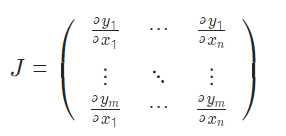

야코비안 행렬의 원소들은 모두 1차 미분계수로 구성되어 있으며, 미소 변화에 관한 선형 변환이다.   
즉, 미소 영역에서 비선형 변환을 선형 변환으로 근사시킨 것이다.

PyTorch에서는 야코비안 행렬 자체를 계산하는 대신, 주어진 입력 벡터 V에 대한 **야코비안 곱(Jacobian Product)Vᵀ• J**을 계산한다.   
이 과정은 **V를 인자로 backward를 호출하면 이뤄진다**.   
V의 크기는 곱하려고 하는 원래 텐서의 크기와 같아야 한다.

In [ ]:
#backward를 동일한 인자로 호출했을때, 기울기 값이 달라진다.

inp = torch.eye(4, 5, requires_grad = True) #torch.eye: zero tensor에 왼쪽 위부터 오른쪽 아래 방향의 대각선으로 1을 채운 4*5 크기의 tensor
out = (inp+1).pow(2).t() #pow(): 거듭제곱 연산하는 메서드
                         #torch.t(): 전치 행렬 구하는 메서드
out.backward(torch.ones_like(out), retain_graph=True)
print(f"First call\n{inp.grad}")
out.backward(torch.ones_like(out), retain_graph=True)
print(f"\nSecond call\n{inp.grad}")
inp.grad.zero_()
out.backward(torch.ones_like(out), retain_graph=True)
print(f"\nCall after zeroing gradients\n{inp.grad}")

First call
tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2., 2., 4., 2.]])

Second call
tensor([[8., 4., 4., 4., 4.],
        [4., 8., 4., 4., 4.],
        [4., 4., 8., 4., 4.],
        [4., 4., 4., 8., 4.]])

Call after zeroing gradients
tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2., 2., 4., 2.]])


위의 코드에서 같은 인자로 backward를 호출했음에도, 기울기 값이 달라지는 것을 확인할 수 있다. 이는 역방향 전파시, PyTorch에서 계산된 기울기의 값을 연산 그래프의 **모든 잎 노드의 grad속성에 누적(accumulate)하기 때문**이다.   

때문에, 여러번 forward 호출 시 제대로 된 기울기 값을 얻기 위해서는 **grad 속성을 먼저 0으로 만들어야** 한다.(*inp.grad.zero_*, 기울기 값이 축적되기 때문)
<br><br>

**+)참고**   

예제에서 이전에 backward()함수를 매개변수 없이 호출했었는데, 이는 **backward(torch.tensor(1.0))과 같은 의미**며, 신경망 훈련에서 함수의 기울기를 계산하는 유용한 방법이다.